In [1]:
import os
import hickle as hkl
from tqdm import tqdm

cluster_dir = '/data/home/xwhan/data/long_c4/clusters'

knn = {}
for dir_ in tqdm(os.listdir(cluster_dir)):
    assert os.path.exists(cluster_dir + f'/{dir_}/knn.hkl')
    knn.update(hkl.load(cluster_dir + f'/{dir_}/knn.hkl'))



knn.update(hkl.load(cluster_dir + f'/cluster_1/knn.hkl'))


  0%|          | 1/256 [02:59<12:43:26, 179.63s/it]


ValueError: Provided argument 'file_obj' does not appear to be a valid hickle file! (Unable to open file (unable to flock file, errno = 11, error message = 'Resource temporarily unavailable'))

In [1]:
import math
import torch

_lambda = 3.5

lambda_to_the_k = 1
e_to_the_minus_lambda = math.exp(-_lambda)
k_factorial = 1
ps = []
for k in range(0, 128):
    ps.append(e_to_the_minus_lambda * lambda_to_the_k / k_factorial)
    lambda_to_the_k *= _lambda
    k_factorial *= k + 1
    if ps[-1] < 0.0000001:
        break
ps = torch.FloatTensor(ps)
print(ps)


tensor([3.0197e-02, 1.0569e-01, 1.8496e-01, 2.1579e-01, 1.8881e-01, 1.3217e-01,
        7.7098e-02, 3.8549e-02, 1.6865e-02, 6.5587e-03, 2.2955e-03, 7.3040e-04,
        2.1303e-04, 5.7355e-05, 1.4339e-05, 3.3457e-06, 7.3188e-07, 1.5068e-07,
        2.9299e-08])


In [11]:
import numpy as np

def random_spans_noise_mask(length, noise_density=0.15, mean_noise_span_length=3):
    orig_length = length

    num_noise_tokens = int(np.round(length * noise_density))
    # avoid degeneracy by ensuring positive numbers of noise and nonnoise tokens.
    num_noise_tokens = min(max(num_noise_tokens, 1), length - 1)
    num_noise_spans = int(np.round(num_noise_tokens / mean_noise_span_length))

    # avoid degeneracy by ensuring positive number of noise spans
    num_noise_spans = max(num_noise_spans, 1)
    num_nonnoise_tokens = length - num_noise_tokens

    # pick the lengths of the noise spans and the non-noise spans
    def _random_segmentation(num_items, num_segments):
        """Partition a sequence of items randomly into non-empty segments.
        Args:
            num_items: an integer scalar > 0
            num_segments: an integer scalar in [1, num_items]
        Returns:
            a Tensor with shape [num_segments] containing positive integers that add
            up to num_items
        """
        mask_indices = np.arange(num_items - 1) < (num_segments - 1)
        np.random.shuffle(mask_indices)
        first_in_segment = np.pad(mask_indices, [[1, 0]])
        segment_id = np.cumsum(first_in_segment)
        # count length of sub segments assuming that list is sorted
        _, segment_length = np.unique(segment_id, return_counts=True)
        return segment_length

    noise_span_lengths = _random_segmentation(num_noise_tokens, num_noise_spans)
    nonnoise_span_lengths = _random_segmentation(num_nonnoise_tokens, num_noise_spans)

    interleaved_span_lengths = np.reshape(
        np.stack([nonnoise_span_lengths, noise_span_lengths], axis=1), [num_noise_spans * 2]
    )



    span_starts = np.cumsum(interleaved_span_lengths)[:-1]
    span_start_indicator = np.zeros((length,), dtype=np.int8)
    span_start_indicator[span_starts] = True
    span_num = np.cumsum(span_start_indicator)
    is_noise = np.equal(span_num % 2, 1)

    # print(span_starts)
    # print(noise_span_lengths)
    # print(len(span_starts), len(noise_span_lengths))

    return is_noise[:orig_length]


random_spans_noise_mask(100)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True,  True,  True,  True, False, False, False, False,
       False,  True,  True,  True,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True])

In [26]:
mask_indices = random_spans_noise_mask(100)
def create_sentinel_ids(mask_indices):
    """
    Sentinel ids creation given the indices that should be masked.
    The start indices of each mask are replaced by the sentinel ids in increasing
    order. Consecutive mask indices to be deleted are replaced with `-1`.
    """
    vocab_size = 1000

    start_indices = mask_indices - np.roll(mask_indices, 1, axis=-1) * mask_indices
    start_indices[0] = mask_indices[0]

    sentinel_ids = np.where(start_indices != 0, np.cumsum(start_indices, axis=-1), start_indices)
    
    sentinel_ids = np.where(sentinel_ids != 0, (sentinel_ids + vocab_size - 1), 0)
    sentinel_ids -= mask_indices - start_indices

    return sentinel_ids

def filter_input_ids(input_ids, sentinel_ids):
    """
    Puts sentinel mask on `input_ids` and fuse consecutive mask tokens into a single mask token by deleting.
    This will reduce the sequence length from `expanded_inputs_length` to `input_length`.
    """
    sentinel_ids = torch.tensor(sentinel_ids)
    print(sentinel_ids)
    print(input_ids)
    input_ids_full = torch.where(sentinel_ids != 0, sentinel_ids, input_ids)
    input_ids = input_ids_full[input_ids_full > 0]
    # input_ids = np.concatenate(
    #     [input_ids, np.full((batch_size, 1), self.tokenizer.eos_token_id, dtype=np.int32)], axis=-1
    # )
    return input_ids

input_ids = np.arange(100, dtype=np.int32)
sentinel_ids = create_sentinel_ids(mask_indices.astype(np.int8))

labels_mask = ~mask_indices
labels_sentinel = create_sentinel_ids(labels_mask.astype(np.int8))

input_ids = torch.tensor(input_ids, dtype=torch.long)

# print(sentinel_ids)
# print(input_ids, len(input_ids))
print(filter_input_ids(input_ids, sentinel_ids))
# print(filter_input_ids(input_ids, labels_sentinel))

# print(sentinel_ids)

tensor([   0,    0,    0,    0,    0, 1000,   -1,   -1,   -1,   -1,   -1,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 1001,   -1,   -1,    0,    0, 1002,   -1,   -1,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 1003,
          -1,    0,    0, 1004])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       

In [3]:
def compute_input_and_target_lengths(inputs_length, noise_density, mean_noise_span_length):
    """This function is copy of `random_spans_helper <https://github.com/google-research/text-to-text-transfer-transformer/blob/84f8bcc14b5f2c03de51bd3587609ba8f6bbd1cd/t5/data/preprocessors.py#L2466>`__ .

    @xwhan In order to fully train the position embeddings, the sample length before noising should be larger than max_source_positions
    """

    def _tokens_length_to_inputs_length_targets_length(tokens_length):
        num_noise_tokens = int(round(tokens_length * noise_density))
        num_nonnoise_tokens = tokens_length - num_noise_tokens
        num_noise_spans = int(round(num_noise_tokens / mean_noise_span_length))
        # inputs contain all nonnoise tokens, sentinels for all noise spans
        # and one EOS token.
        _input_length = num_nonnoise_tokens + num_noise_spans
        _output_length = num_noise_tokens + num_noise_spans
        return _input_length, _output_length

    tokens_length = inputs_length

    while _tokens_length_to_inputs_length_targets_length(tokens_length + 1)[0] <= inputs_length:
        tokens_length += 1

    inputs_length, targets_length = _tokens_length_to_inputs_length_targets_length(tokens_length)

    # minor hack to get the targets length to be equal to inputs length
    # which is more likely to have been set to a nice round number.
    if noise_density == 0.5 and targets_length > inputs_length:
        tokens_length -= 1
        targets_length -= 1
    return tokens_length, targets_length


print(compute_input_and_target_lengths(8192 - 2, 0.05, 10))

(8576, 472)


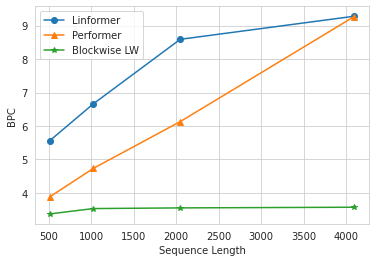

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns

block = [3.37, 3.53, 3.55, 3.57]
performer = [3.88, 4.73, 6.13, 9.27]
linformer = [5.56, 6.66, 8.59, 9.28]
length = [512, 1024, 2048, 4096]

sns.set_style("whitegrid", {'legend.frameon':True})
plt.ylabel("BPC")
plt.xlabel("Sequence Length")
plt.plot(length, linformer, label='Linformer', marker='o')
plt.plot(length, performer, label='Performer', marker='^')
plt.plot(length, block, label='Blockwise LW', marker='*')
plt.legend()

plt.savefig('addition.pdf')

In [2]:
import math
from typing import List

import numpy as np
import torch
import xformers.components.attention.attention_patterns as AP
from xformers.triton.utils import gpu_capabilities_older_than_70

print(gpu_capabilities_older_than_70())

# SEQ = 20
# BLOCK_SIZE = 4
# blocks = SEQ // BLOCK_SIZE
# HEADS = 1
# causal_layout = torch.tril(torch.ones([HEADS, blocks, blocks]))
# causal_mask = torch.tril(torch.ones((SEQ, SEQ)))
# print(causal_layout)



False


In [11]:
fix_rate = 0.02
risk_rate = 0.05

growth_rate_near = 0.15
growth_rate_long = 0.03

current_cash = 428 # millions

years = 3 # growth years

value = 0
for year in range(1, years + 1):
    value += current_cash * (1 + growth_rate_near) ** year / (1 + fix_rate + risk_rate) ** year

value += (current_cash * (1 + growth_rate_near) ** year * (1 + growth_rate_long) / (fix_rate + risk_rate - growth_rate_long)) / (1 + fix_rate + risk_rate) ** years

print(value)

13898.391297028866


In [8]:
(428 / 258) ** (1 / 4)


1.1348958704923795